In [2]:
import duckdb as dd
conn = dd.connect('/home/prithwijit/programming/python/imp_projects/age_gender_project/data/age_gender.db')
conn.execute('show tables').df()
conn.execute("""
select * from feature_table limit 5
""").df()

,images,ftr_1,ftr_2,ftr_3,ftr_4,ftr_5,ftr_6,ftr_7,ftr_8,ftr_9,...,ftr_503,ftr_504,ftr_505,ftr_506,ftr_507,ftr_508,ftr_509,ftr_510,ftr_511,ftr_512
0,25_1_0_20170117140138784.jpg.chip.jpg,-0.006319,0.003926,0.080073,-0.014776,-0.026793,-0.055246,-0.037815,-0.015999,0.067364,...,0.084006,0.064676,-0.013454,-0.005766,-0.005644,-0.051589,-0.009109,-0.013387,-0.048576,0.019110
1,26_1_4_20161221193701030.jpg.chip.jpg,-0.046969,-0.028406,-0.051347,0.019398,0.032081,0.062143,0.019842,0.024617,-0.034310,...,-0.022482,-0.034181,0.024661,-0.000375,0.028044,-0.038985,-0.025334,-0.068647,0.034177,0.063220
2,48_1_0_20170109220537701.jpg.chip.jpg,0.015135,0.007612,-0.030217,0.005765,0.010932,0.035206,-0.010927,-0.014898,-0.062559,...,-0.015079,0.033631,-0.023980,-0.041613,0.051798,-0.009173,-0.002913,0.075261,-0.003414,0.036220
3,37_0_0_20170117183624982.jpg.chip.jpg,0.059187,-0.066999,-0.010596,-0.017627,-0.066628,-0.047047,-0.004677,0.004264,0.003729,...,-0.024074,0.013643,-0.059502,0.042804,0.024640,-0.016044,-0.077180,0.018697,-0.036168,-0.052599
4,32_0_2_20170116162124916.jpg.chip.jpg,0.039318,0.001895,0.004720,0.005178,0.003709,0.029632,-0.011737,0.061862,-0.001186,...,0.021781,-0.097252,-0.004775,-0.013594,-0.029582,0.032389,0.044868,-0.088314,-0.104643,0.044904


In [3]:
import sys
sys.executable

'/home/prithwijit/programming/python/imp_projects/age_gender_project/.venv/bin/python'

In [4]:
import subprocess as sb
import numpy as np
import fireducks.pandas as pd
import os
import matplotlib.pyplot as plt
import warnings
from tensorflow import keras
from loguru import logger
from sklearn.model_selection import train_test_split
import gc
import cv2
from rich import print
import tensorflow as tf
from keras_facenet import FaceNet
from PIL import Image

pd.options.mode.chained_assignment = None

# Suppress TensorFlow logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Suppress all warnings
warnings.filterwarnings("ignore")

2025-07-29 20:36:42.462737: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-29 20:36:42.464656: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-29 20:36:42.499065: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-29 20:36:42.499101: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-29 20:36:42.499136: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [5]:
password = "1379"
is_mounted = sb.run('lsblk -o MOUNTPOINT,TYPE | grep /mnt/usb', shell = True, text = True, capture_output=True)
mount_command = "sudo -S mount /dev/sda4 /mnt/usb/"
unmount_command = "sudo -S umount /mnt/usb/"
if (is_mounted.stdout == ''):
    mounted_path = sb.run(mount_command, input=password + "\n", shell = True, text=True, capture_output=True)
    print('data path has been mounted to /mnt/usb!!!')
else:
    print(f"Already mounted, mountpoint --- {is_mounted.stdout}")
data_path = "/mnt/usb/python/project_dataset/UTKFace/"
data = os.listdir(data_path)

Already mounted, mountpoint --- /mnt/usb   part

In [6]:
data[:10]

['17_0_3_20170117134709342.jpg.chip.jpg',
 '24_0_1_20170102233456210.jpg.chip.jpg',
 '32_0_1_20170117140659728.jpg.chip.jpg',
 '26_1_2_20170103181524137.jpg.chip.jpg',
 '47_1_1_20170113012448233.jpg.chip.jpg',
 '58_0_3_20170119195320690.jpg.chip.jpg',
 '45_0_0_20170117135112380.jpg.chip.jpg',
 '10_1_0_20170103200654246.jpg.chip.jpg',
 '30_1_3_20170117150440114.jpg.chip.jpg',
 '29_1_2_20170116163132225.jpg.chip.jpg']

In [7]:
# for i in range(5):
#     sb.run(f"mkdir -p sub_dir{i}", shell = True, text = True)
#     for image in data[5000*i:5000*(i+1)]:
#         sb.run("cp " + data_path + image + f" sub_dir{i}/", shell = True, text = True)

In [8]:
for i in range(5):
    print(len(os.listdir(f'sub_dir{i}')))

5001

4999

5000

5000

3708

In [9]:
# i = os.listdir(f'sub_dir0')[0]

In [10]:
# from PIL import Image
# display(Image.open('sub_dir0/' + i))
# data[100]

In [11]:
x = sb.run(f"ls", shell = True, text = True, capture_output = True)
(x.stdout).split('\n')

['age_gender.db',
 'age_gender_identification.ipynb',
 'augmented_dir',
 'catboost_info',
 'image_encoding.py',
 'jlab.log',
 'sub_dir0',
 'sub_dir1',
 'sub_dir2',
 'sub_dir3',
 'sub_dir4',
 'test.pkl',
 '']

In [12]:
data_df = pd.DataFrame({'images' : data})
data_df[['age', 'gender', 'race', 'photo']] = data_df['images'].str.split('_',expand = True)
data_df['images'] = data_path + data_df['images']
data_df.drop('photo', axis = 1, inplace = True)
data_df = data_df[data_df.race.isin(['0','1','2','3'])]

In [13]:
def age_interval(x):
    if x/5 <= 20:
        for i in range(20):
            if (i*5) <= x <= ((i+1)*5):
                return f'{i*5 + 1} to {(i+1)*5}'
                break
            else:
                continue
    else:
        return '100+'

data_df['age_interval'] = data_df['age'].astype(int).apply(age_interval)
data_df.head()

,images,age,gender,race,age_interval
0,/mnt/usb/python/project_dataset/UTKFace/17_0_3...,17,0,3,16 to 20
1,/mnt/usb/python/project_dataset/UTKFace/24_0_1...,24,0,1,21 to 25
2,/mnt/usb/python/project_dataset/UTKFace/32_0_1...,32,0,1,31 to 35
3,/mnt/usb/python/project_dataset/UTKFace/26_1_2...,26,1,2,26 to 30
4,/mnt/usb/python/project_dataset/UTKFace/47_1_1...,47,1,1,46 to 50


## Gender

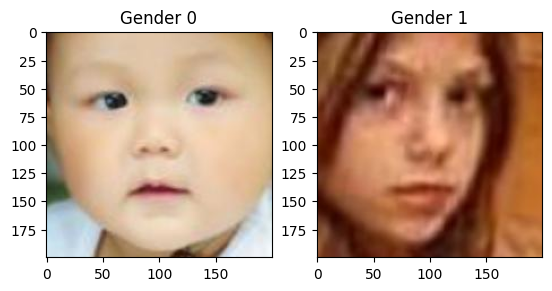

In [14]:
gender_plot_dict = {
    '0': data_df[data_df.gender == '0'].sample()['images'].values[0],
    '1': data_df[data_df.gender == '1'].sample()['images'].values[0]
}
fig, ax = plt.subplots(1,2)
ax[0].imshow(plt.imread(gender_plot_dict['0']))
ax[0].set_title("Gender 0")
ax[1].imshow(plt.imread(gender_plot_dict['1']))  
ax[1].set_title("Gender 1")
plt.show()

In [15]:
def bw_check(x):
    return ((plt.imread(x)[:,:,0] == plt.imread(x)[:,:,1]).sum() == 40000) | \
    ((plt.imread(x)[:,:,0] == plt.imread(x)[:,:,2]).sum() == 40000) | \
    ((plt.imread(x)[:,:,1] == plt.imread(x)[:,:,2]).sum() == 40000)

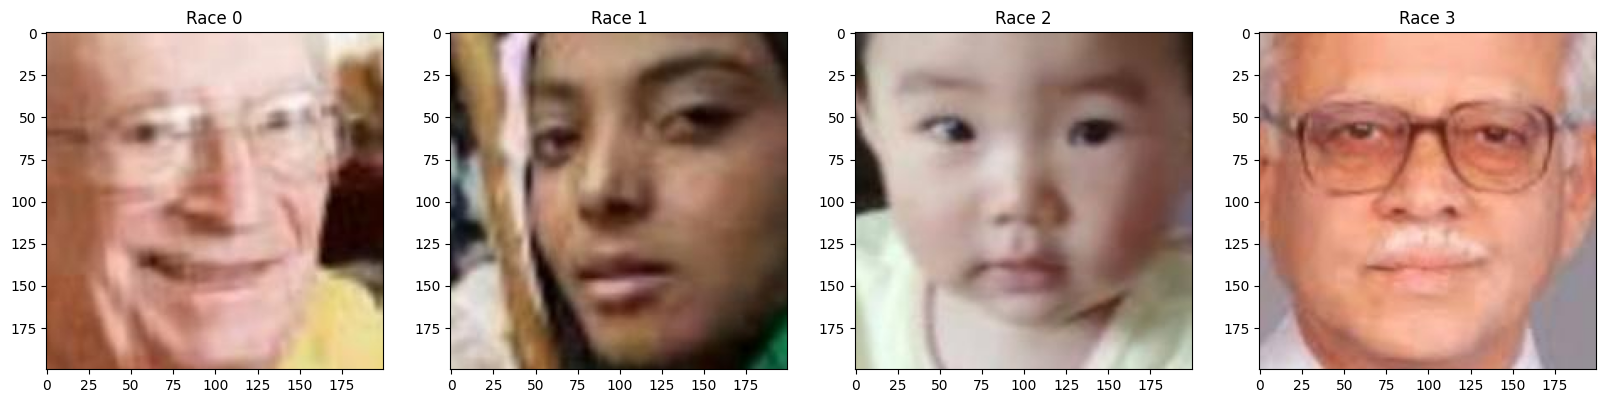

In [16]:
gender_plot_dict = {
    '0': data_df[data_df.race == '0'].sample()['images'].values[0],
    '1': data_df[data_df.race == '1'].sample()['images'].values[0],
    '2': data_df[data_df.race == '2'].sample()['images'].values[0],
    '3': data_df[data_df.race == '3'].sample()['images'].values[0],
    # '4': data_df[data_df.race == '4'].sample()['images'].values[0]
    
}
fig, ax = plt.subplots(1,4, figsize=(20, 5))
ax[0].imshow(plt.imread(gender_plot_dict['0']))
ax[0].set_title("Race 0")
ax[1].imshow(plt.imread(gender_plot_dict['1']))  
ax[1].set_title("Race 1")
ax[2].imshow(plt.imread(gender_plot_dict['2']))  
ax[2].set_title("Race 2")
ax[3].imshow(plt.imread(gender_plot_dict['3']))
ax[3].set_title("Race 3")
# ax[4].imshow(plt.imread(gender_plot_dict['4']))
# ax[4].set_title("Race 4")
plt.show()

gender
Male      0.52837
Female    0.47163
Name: proportion, dtype: float64

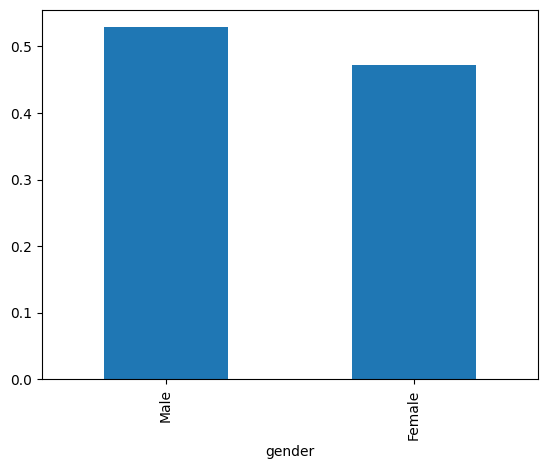

In [17]:
data_df.gender.map({0: 'Male', 1: 'Female'}).value_counts(normalize = True).plot(kind = 'bar')
display(data_df.gender.map({0: 'Male', 1: 'Female'}).value_counts(normalize = True))
plt.show()

race
0    0.457820
1    0.205606
3    0.180575
2    0.155999
Name: proportion, dtype: float64

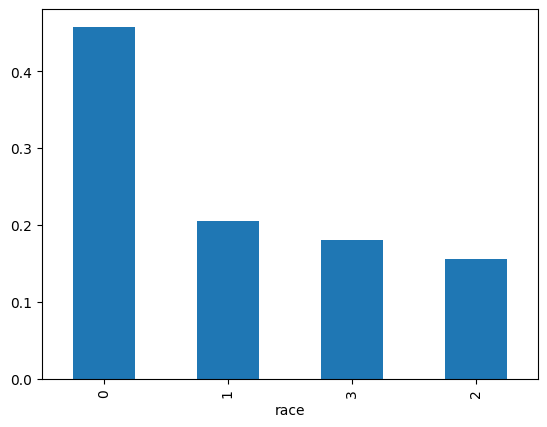

In [18]:
data_df.race.value_counts(normalize = True).plot(kind = 'bar')
display(data_df.race.value_counts(normalize = True))
plt.show()

age
26    0.091809
1     0.044701
28    0.038750
35    0.037251
24    0.034480
Name: proportion, dtype: float64

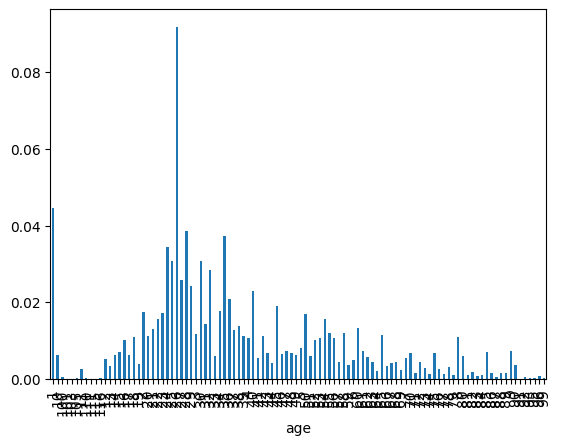

In [19]:
data_df.age.value_counts(normalize = True).sort_index().plot(kind = 'bar')
display(data_df.age.value_counts(normalize = True).sort_values(ascending = False).head())
plt.show()

,proportion
age_interval,
26 to 30,0.211511
21 to 25,0.111162
31 to 35,0.103848
1 to 5,0.092991
36 to 40,0.081588


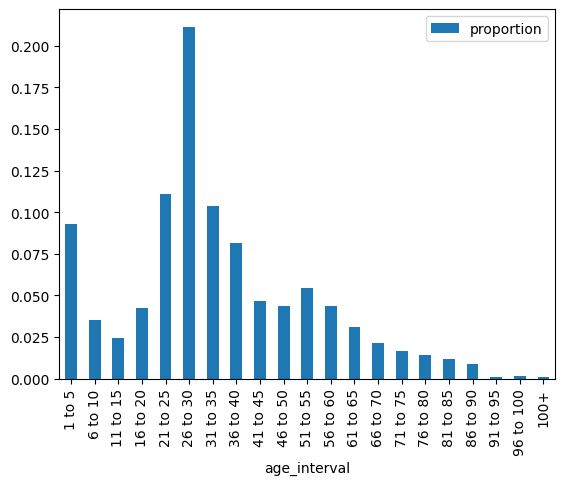

In [20]:
age_interval_index = pd.DataFrame({'age_interval': [f'{i*5 + 1} to {(i+1)*5}' for i in range(20)] + ['100+']})
age_df = age_interval_index.merge(data_df['age_interval'].value_counts(normalize = True).reset_index(), on = 'age_interval', how = 'left')
age_df.index = age_df['age_interval']
age_df.drop('age_interval', axis = 1, inplace = True)
age_df.plot(kind = 'bar')
display(age_df.sort_values(by = 'proportion', ascending = False).head())
plt.show()

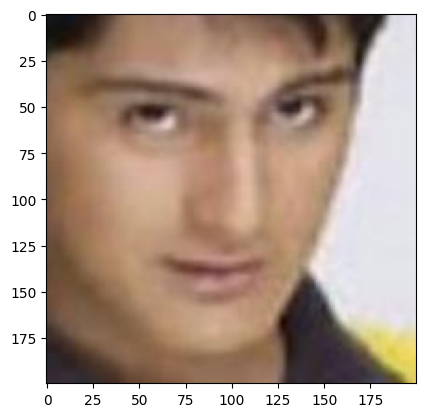

In [21]:
data_dir = '/mnt/usb/python/project_dataset/UTKFace/'
image_list = os.listdir(data_dir)
image_path = data_dir + image_list[0]


image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)

(4500, 3000, 3)

(200, 200, 3)

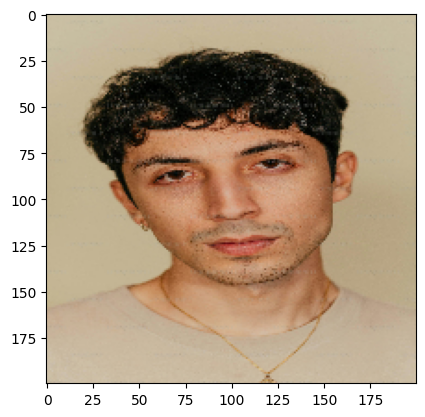

In [22]:
im_path = '/home/prithwijit/Pictures/premium_photo-1671656349322-41de944d259b.jpeg'
image = cv2.imread(im_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_2 = cv2.resize(image, (200, 200))
print(image.shape)
plt.imshow(image)
plt.imshow(image_2)
print(image_2.shape)

In [23]:
from keras_facenet import FaceNet

embedder = FaceNet() 
def get_embedding(image_path):                                                                                                  
    try :
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (200, 200))
        embd = embedder.embeddings([image])[0].reshape(1, -1)                                                                   
        return embd                                                                                                             
    except:                                                                                                                     
        logger.error(f'image embeddings failed :( for the image {image_path}')


In [24]:
pd.DataFrame(get_embedding(im_path))

1/1 [==============================] - 1s 1s/step


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.028556,-0.008355,-0.007518,0.03791,0.044438,0.082399,-0.025902,0.03277,-0.085457,0.063816,...,0.060624,-0.101754,0.028226,-0.027281,0.033708,-0.009279,0.014855,-0.076283,0.013748,0.045781


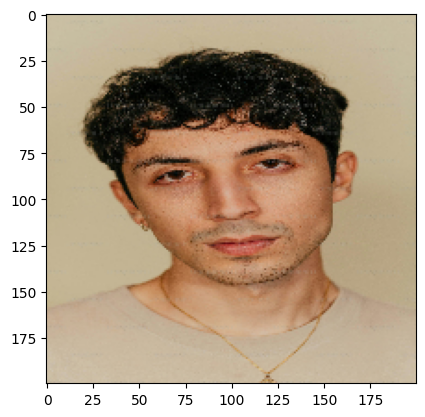

In [25]:
plt.imshow(cv2.resize(image, (200, 200)))

In [26]:
import duckdb as dd
conn = dd.connect('age_gender.db')
schema = 'images VARCHAR PRIMARY KEY,' + ', '.join([f'ftr_{i} DOUBLE' for i in range(1,513)])
conn.execute(f"create table if not exists augmentation_table ( {schema} )") #

from keras_facenet import FaceNet
embedder = FaceNet()

data_dir = '/mnt/usb/python/project_dataset/UTKFace/'
def get_embedding(image_path):
    try :
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        embd = embedder.embeddings([image])[0].reshape(1, -1)
        return embd
    except:
        pass

image_list = os.listdir(data_dir)
data_list = []
error_images = []
for image in image_list:
    try:
        embd = get_embedding(data_dir + image)
        if len(embd) > 0:
            data_list.append([image] + list(embd[0]))
    except:
        error_images.append(data_dir + image)
        logger.error(data_dir + image)

pdf = pd.DataFrame(data_list).rename(columns = {0:'images'} | {i:f'ftr_{i}' for i in range(1,513)})
conn.execute("insert or replace into augmentation_table select * from pdf")
del pdf, data_list

gc.collect()
# print(f'iteration {i} completed')
conn.close

1/1 [==============================] - 0s 50ms/step


<bound method PyCapsule.close of <duckdb.duckdb.DuckDBPyConnection object at 0x71d2d0675230>>

In [27]:
# import cv2
# import numpy as np
# import os
# from keras_facenet import FaceNet

# # data_dir = 'sub_dir0/'
# # image_list = os.listdir(data_dir)
# embedder = FaceNet()


# # image_path = os.path.join(data_dir, image_list[3])
# image = cv2.imread('sub_dir1/65_0_1_20170116204818030.jpg.chip.jpg')

# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# embedding = embedder.embeddings([image])
# embedding[0]

In [35]:
import duckdb as dd
conn = dd.connect('age_gender.db')
full_df = conn.execute('select * from summary_table').df()
# aug_df = conn.execute('select * from augmentation_table').df()
# conn.execute('drop table summary_table')
conn.close()

In [36]:
conn.execute('show tables').df().name.tolist()

ConnectionException: Connection Error: Connection already closed!

In [37]:
full_df = full_df.drop_duplicates('images')
data_df['is_bw'] = data_df['images'].apply(lambda x: bw_check(x))
data_df['images'] = data_df['images'].apply(lambda x: x.split('/')[-1])
merged_df = full_df.merge(data_df, on = 'images', how = 'inner')
merged_df.index = merged_df.images
merged_df = merged_df.drop('images', axis = 1)
print(merged_df.shape)
merged_df.head(2)


(22012, 517)

,ftr_1,ftr_2,ftr_3,ftr_4,ftr_5,ftr_6,ftr_7,ftr_8,ftr_9,ftr_10,...,ftr_508,ftr_509,ftr_510,ftr_511,ftr_512,age,gender,race,age_interval,is_bw
images,,,,,,,,,,,,,,,,,,,,,
25_1_0_20170117140138784.jpg.chip.jpg,-0.006319,0.003926,0.080073,-0.014776,-0.026793,-0.055246,-0.037815,-0.015999,0.067364,0.021011,...,-0.051589,-0.009109,-0.013387,-0.048576,0.01911,25,1,0,21 to 25,False
48_1_0_20170109220537701.jpg.chip.jpg,0.015135,0.007612,-0.030217,0.005765,0.010932,0.035206,-0.010927,-0.014898,-0.062559,-0.046212,...,-0.009173,-0.002913,0.075261,-0.003414,0.03622,48,1,0,46 to 50,False


In [38]:
from sklearn.model_selection import train_test_split
age_df = merged_df

In [39]:
## Filter
merged_df = merged_df[(merged_df.is_bw == False) & (~merged_df.age_interval.isin(['1 to 5']))]


train_df, val_df = train_test_split(merged_df, test_size = 0.1, shuffle = True, stratify = merged_df['race'].values, random_state = 30980)
val_df, test_df = train_test_split(val_df, test_size = 0.2, shuffle = True, random_state = 30980)
print(train_df.shape, val_df.shape, test_df.shape)

x_train = train_df.drop(['age',	'gender', 'race', 'age_interval'], axis = 1)
x_val = val_df.drop(['age',	'gender', 'race', 'age_interval'], axis = 1)
x_test = test_df.drop(['age', 'gender', 'race', 'age_interval'], axis = 1)

y_train_age = train_df.age
y_train_gender = train_df.gender
y_train_race = train_df.race
y_train_age_interval = train_df.age_interval

y_val_age = val_df.age
y_val_gender = val_df.gender
y_val_race = val_df.race
y_val_age_interval = val_df.age_interval

y_test_age = test_df.age
y_test_gender = test_df.gender
y_test_race = test_df.race
y_test_age_interval = test_df.age_interval

(17442, 517)
(1551, 517)
(388, 517)

In [ ]:
# aug_df['images'] = aug_df['images'].apply(lambda x: x.split('/')[-1])
# aug_df[['age', 'gender', 'race', 'photo']] = aug_df['images'].str.split('_',expand = True)
# # aug_df['images'] = data_path + aug_df['images']
# aug_df.drop('photo', axis = 1, inplace = True)
# aug_df = aug_df[aug_df.race.isin(['0','1','2','3','4'])]
# aug_df['age_interval'] = aug_df['age'].astype(int).apply(age_interval)
# aug_df.index = aug_df.images
# aug_df = aug_df.drop('images', axis = 1)

In [ ]:
# aug_df.head(10)

In [ ]:
# import cv2
# import random
# # def augment_and_save(data, col, image_dir, save_dir):
# #     conn = dd.connect('age_gender.db')
# #     schema = 'images VARCHAR PRIMARY KEY,' + ', '.join([f'ftr_{i} DOUBLE' for i in range(1,513)])
# #     conn.execute(f"create table if not exists augmentation_table ( {schema} )")

# #     try :
# #         print(conn.execute(f'select {col}, count(*) from augmentation_table group by {col}'))
# #     except:
# #         pass

# data = train_df
# col = 'race'
# image_dir = '/mnt/usb/python/project_dataset/UTKFace/'
# save_dir = '/home/prithwijit/programming/python/age_gender_project/notebooks/augmented_dir/'



# category = str(input())
# race_count = data[col].value_counts()
# race_dict = (race_count.max() - race_count).to_dict()
# print(race_dict)
# # for i in race_dict:
# image_list = data[data.race == category].index.tolist()
# image_sublist = random.choices(image_list, k = race_dict[category])
# count = 0

# data_list = []
# error_images = []
# for image in image_sublist[:10]:
#     img = cv2.imread(image_dir + image)
#     img = cv2.flip(img, 1)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     count += 1
#     base_name = image.split('.')[0] + str(count) + '.jpg'

#     try:
#         embd = embedder.embeddings([img])[0].reshape(1, -1)
#         if len(embd) > 0:
#             data_list.append([base_name] + list(embd[0]))
#     except:
#         error_images.append(image_dir + image)
#         logger.error(image_dir + image)

# pdf = pd.DataFrame(data_list).rename(columns = {0:'images'} | {i:f'ftr_{i}' for i in range(1,513)})
# # conn.execute("insert or replace into augmentation_table select * from pdf")
# # del pdf, data_list
#     # return error_images

In [ ]:
# import cv2
# import random
# def augment_and_save(data, col, image_dir, save_dir):
#     conn = dd.connect('age_gender.db')
#     schema = 'images VARCHAR PRIMARY KEY,' + ', '.join([f'ftr_{i} DOUBLE' for i in range(1,513)])
#     conn.execute(f"create table if not exists augmentation_table ( {schema} )")

#     embedder = FaceNet()
#     category = str(input())
#     race_count = data[col].value_counts()
#     race_dict = (race_count.max() - race_count).to_dict()
#     print(race_dict)
#     # for i in race_dict:
#     image_list = data[data.race == category].index.tolist()
#     image_sublist = random.choices(image_list, k = race_dict[category])
#     count = 0

#     data_list = []
#     error_images = []
#     for image in image_sublist:
#         img = cv2.imread(image_dir + image)
#         img = cv2.flip(img, 1)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         count += 1
#         base_name = image.split('.')[0] + str(count) + '.jpg'
    
#         try:
#             embd = embedder.embeddings([img])[0].reshape(1, -1)
#             if len(embd) > 0:
#                 data_list.append([base_name] + list(embd[0]))
#         except:
#             error_images.append(image_dir + image)
#             logger.error(image_dir + image)

#     pdf = pd.DataFrame(data_list).rename(columns = {0:'images'} | {i:f'ftr_{i}' for i in range(1,513)})
#     conn.execute("insert or replace into augmentation_table select * from pdf")
#     del pdf, data_list
    

In [ ]:
# augment_and_save(train_df, 'race', '/mnt/usb/python/project_dataset/UTKFace/', '/home/prithwijit/programming/python/age_gender_project/notebooks/augmented_dir/')

In [ ]:
# x_train = pd.concat([x_train, aug_df.drop(['age', 'gender', 'race', 'age_interval'], axis = 1)])

# y_train_age = pd.concat([train_df.age, aug_df.age])
# y_train_gender = pd.concat([train_df.gender, aug_df.gender])
# y_train_race = pd.concat([train_df.race, aug_df.race])
# y_train_age_interval = pd.concat([train_df.age_interval, aug_df.age_interval])

In [40]:
x_train.shape, y_train_age.shape, y_train_gender.shape, y_train_age.shape,y_train_age_interval.shape

((17442, 513), (17442,), (17442,), (17442,), (17442,))

In [41]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.fit_transform(x_val)
x_test_scaled = scaler.fit_transform(x_test)


pca = PCA(n_components=50)
x_train_pca = pca.fit_transform(x_train)
x_val_pca = pca.transform(x_val)
x_test_pca = pca.transform(x_test)

In [42]:
pca.explained_variance_ratio_.sum()

0.9999979415565351

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier, CatBoostRegressor
from xgboost import XGBClassifier, XGBRegressor
import seaborn as sns
from sklearn.linear_model import LinearRegression


from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import classification_report as cr, confusion_matrix, accuracy_score, root_mean_squared_error, mean_absolute_error

In [45]:
model_dict = {'LR': LogisticRegression, 'KNN': KNeighborsClassifier, 'GBC': GradientBoostingClassifier, 'catboost': CatBoostClassifier, 'xgb': XGBClassifier}

In [35]:
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(x_train_pca, x_val_pca, y_train_gender, y_val_gender)

 97%|█████████▋| 31/32 [01:30<00:01,  1.21s/it]

[LightGBM] [Info] Number of positive: 8242, number of negative: 9200
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 17442, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.472538 -> initscore=-0.109960
[LightGBM] [Info] Start training from score -0.109960


100%|██████████| 32/32 [01:30<00:00,  2.84s/it]


In [36]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.97,0.97,0.97,0.97,5.57
KNeighborsClassifier,0.96,0.96,0.96,0.96,0.12
QuadraticDiscriminantAnalysis,0.96,0.96,0.96,0.96,0.14
ExtraTreesClassifier,0.96,0.96,0.96,0.96,1.71
NuSVC,0.95,0.95,0.95,0.95,18.07
LGBMClassifier,0.95,0.95,0.95,0.95,0.60
RandomForestClassifier,0.95,0.95,0.95,0.95,11.78
BaggingClassifier,0.90,0.90,0.90,0.90,10.25
LogisticRegression,0.87,0.87,0.87,0.87,0.19


In [8]:
from scipy.stats import uniform
uniform(0.1, 10)

array([1.50203695, 9.50180582, 4.48380387, 2.38580077, 1.23462757,
       2.265823  , 2.32664863, 0.33137302, 4.30835261, 8.52552984])

In [58]:
svc = SVC()

# Define hyperparameter grid
param_dist = {
    'C': uniform(0.1, 10),  # Regularization parameter
    'gamma': uniform(0.01, 1),  # Kernel coefficient
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']  # Kernel type
}
# Perform Randomized Search CV
random_search = RandomizedSearchCV(
    svc, param_distributions=param_dist, 
    n_iter=20, scoring='accuracy', 
    cv=5, random_state=42, verbose=1, n_jobs=-1
)
# Fit model
random_search.fit(x_train_pca, y_train_gender)
# Best parameters & accuracy
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Best Parameters:
{'C': 6.72522284353982, 'gamma': 0.32171107608941096, 'kernel': 'rbf'}

Best Score: 0.967549585722888

In [27]:
import pandas as pd
pd.DataFrame({
    'math': 100,
    'stat': 90
}, index = ['accuracy']).T.sort_values(by = 'accuracy').head(1).index[0]

'stat'

In [11]:
import joblib
joblib.dump({'C': 6.72522284353982, 'gamma': 0.32171107608941096, 'kernel': 'rbf'}, 'test.pkl')

['test.pkl']

In [15]:
loaded_model = joblib.load('test.pkl')
loaded_model.predict(uniform(0.1, 10).rvs(50))

AttributeError: 'dict' object has no attribute 'predict'

In [37]:
model = SVC(**{'C': 6.72522284353982, 'gamma': 0.32171107608941096, 'kernel': 'rbf'})

model.fit(x_train_pca, y_train_gender)
y_train_pred_gender = model.predict(x_train_pca)
print(cr(y_train_gender.values, y_train_pred_gender))


y_val_pred_gender = model.predict(x_val_pca)
print(cr(y_val_gender.values, y_val_pred_gender))

precision    recall  f1-score   support

           0       0.98      0.97      0.98      9200
           1       0.97      0.98      0.97      8242

    accuracy                           0.98     17442
   macro avg       0.98      0.98      0.98     17442
weighted avg       0.98      0.98      0.98     17442

precision    recall  f1-score   support

           0       0.98      0.97      0.98       845
           1       0.97      0.97      0.97       706

    accuracy                           0.97      1551
   macro avg       0.97      0.97      0.97      1551
weighted avg       0.97      0.97      0.97      1551

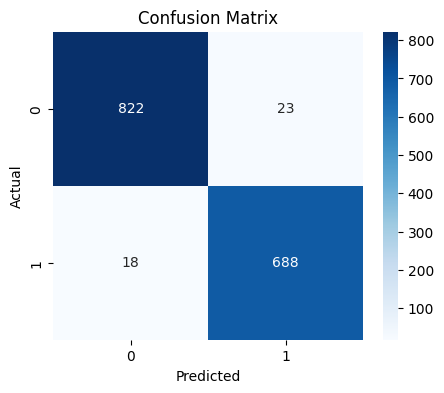

In [38]:
cm = confusion_matrix(y_val_gender.values, y_val_pred_gender)

# Plot using Seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")#, xticklabels=["Pred 0", "Pred 1"], yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [39]:
models, predictions = clf.fit(x_train_pca, x_val_pca, y_train_race, y_val_race)

'tuple' object has no attribute '__name__'
Invalid Classifier(s)


 84%|████████▍ | 27/32 [01:15<00:12,  2.58s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 17442, number of used features: 50
[LightGBM] [Info] Start training from score -0.764674
[LightGBM] [Info] Start training from score -1.507437
[LightGBM] [Info] Start training from score -2.029893
[LightGBM] [Info] Start training from score -1.705465


100%|██████████| 32/32 [01:17<00:00,  2.41s/it]


In [40]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.93,0.92,None,0.93,4.95
LGBMClassifier,0.92,0.91,None,0.92,1.48
LogisticRegression,0.92,0.91,None,0.92,0.23
KNeighborsClassifier,0.91,0.91,None,0.91,0.10
NearestCentroid,0.91,0.91,None,0.91,0.09
SGDClassifier,0.91,0.91,None,0.92,0.47
LinearSVC,0.92,0.91,None,0.92,0.55
CalibratedClassifierCV,0.92,0.91,None,0.92,1.09
QuadraticDiscriminantAnalysis,0.91,0.91,None,0.91,0.13


In [67]:
random_search.fit(x_train_pca, y_train_race)
# Best parameters & accuracy
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Best Parameters:
{'C': 1.833646535077721, 'gamma': 0.4010606075732408, 'kernel': 'rbf'}

Best Score: 0.9226006012342853

In [47]:
model = SVC(**{'C': 1.833646535077721, 'gamma': 0.4010606075732408, 'kernel': 'rbf'})

model.fit(x_train_pca, y_train_race)
y_train_pred_race = model.predict(x_train_pca)
print(cr(y_train_race.values, y_train_pred_race))


y_val_pred_race = model.predict(x_val_pca)
print(cr(y_val_race.values, y_val_pred_race))

precision    recall  f1-score   support

           0       0.96      0.95      0.95      8119
           1       0.93      0.94      0.94      3863
           2       0.96      0.94      0.95      2291
           3       0.89      0.91      0.90      3169

    accuracy                           0.94     17442
   macro avg       0.93      0.93      0.93     17442
weighted avg       0.94      0.94      0.94     17442

precision    recall  f1-score   support

           0       0.95      0.95      0.95       728
           1       0.91      0.93      0.92       341
           2       0.96      0.92      0.94       192
           3       0.88      0.89      0.89       290

    accuracy                           0.93      1551
   macro avg       0.93      0.92      0.92      1551
weighted avg       0.93      0.93      0.93      1551

In [46]:
# model = model_dict['KNN'](n_neighbors = 15)
# model.fit(x_train_pca, y_train_race)#, verbose = False)
# y_val_pred_race = model.predict(x_val_pca)
# print('=============== Race Prediction ===============')
# print('Train Accuracy : ', accuracy_score(y_train_race.values, model.predict(x_train_pca)))
# print('Val Accuracy : ', accuracy_score(y_val_race.values, y_val_pred_race))

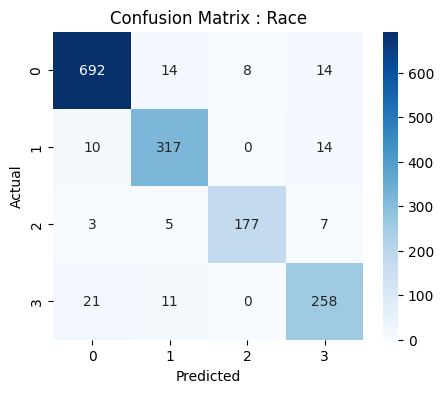

In [48]:
cm = confusion_matrix(y_val_race.values, y_val_pred_race)

# Plot using Seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")#, xticklabels=["Pred 0", "Pred 1"], yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix : Race")
plt.show()

## **Age Regression**

In [46]:
LR = LinearRegression()
LR.fit(x_train_pca, y_train_age.values.astype(int).reshape(-1,1))
y_train_age_pred = np.round(LR.predict(x_train_pca)).astype(int)
y_val_age_pred = np.round(LR.predict(x_val_pca)).astype(int)

In [47]:
print(np.sqrt(np.mean((y_train_age.values.astype(int).reshape(-1,1) - y_train_age_pred)**2)))
print(np.sqrt(np.mean((y_val_age.values.astype(int).reshape(-1,1) - y_val_age_pred)**2)))


9.769711037451584

9.675355707120879

In [71]:
%%time
from lazypredict.Supervised import LazyRegressor
# Create LazyRegressor
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(x_train_pca, x_val_pca, y_train_age, y_val_age)

print(models)

 98%|▉| 41/42 [41:2

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 17442, number of used features: 50
[LightGBM] [Info] Start training from score 37.388602


100%|█| 42/42 [41:2


Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
MLPRegressor                                 0.79       0.79  8.11        9.55
SVR                                          0.77       0.78  8.34       12.67
NuSVR                                        0.77       0.77  8.49       14.17
LGBMRegressor                                0.76       0.77  8.55        0.52
HistGradientBoostingRegressor                0.76       0.77  8.58        0.54
ExtraTreesRegressor                          0.75       0.76  8.78       12.68
XGBRegressor                                 0.74       0.74  9.01        0.92
RandomForestRegressor                        0.73       0.73  9.18       70.70
PoissonRegressor                             0.71       0.72  9.51        0.20
GradientBoostingRegressor                    0.70       0.71  9.60       26.43
ElasticNetCV                                 0.70       0.71  9.67        0.21
LassoCV                                      0.70       0.71  9.67        0.27
BayesianRidge                                0.70       0.71  9.67        0.09
HuberRegressor                               0.70       0.71  9.67        0.20
Ridge                                        0.70       0.71  9.67        0.03
LinearRegression                             0.70       0.71  9.67        0.10
LassoLarsIC                                  0.70       0.71  9.67        0.15
LassoLarsCV                                  0.70       0.71  9.67        0.16
TransformedTargetRegressor                   0.70       0.71  9.67        0.05
LarsCV                                       0.70       0.71  9.67        0.15
Lars                                         0.70       0.71  9.67        0.05
SGDRegressor                                 0.70       0.71  9.68        0.18
LinearSVR                                    0.69       0.70  9.70        0.39
BaggingRegressor                             0.69       0.70  9.82        7.14
RidgeCV                                      0.68       0.69  9.87        0.17
LassoLars                                    0.61       0.62 10.95        0.05
Lasso                                        0.61       0.62 10.95        0.08
ElasticNet                                   0.56       0.58 11.60        0.03
TweedieRegressor                             0.52       0.53 12.16        0.10
OrthogonalMatchingPursuitCV                  0.51       0.53 12.24        0.08
OrthogonalMatchingPursuit                    0.51       0.53 12.24        0.07
GammaRegressor                               0.51       0.53 12.26        0.09
AdaBoostRegressor                            0.41       0.43 13.42        6.00
PassiveAggressiveRegressor                   0.33       0.36 14.32        0.11
ExtraTreeRegressor                           0.28       0.30 14.93        0.21
DecisionTreeRegressor                        0.26       0.29 15.05        1.09
DummyRegressor                              -0.03      -0.00 17.83        0.03
QuantileRegressor                           -0.12      -0.08 18.53     2236.73
RANSACRegressor                             -0.77      -0.71 23.35        0.39
KernelRidge                                 -3.65      -3.50 37.82       23.72
GaussianProcessRegressor                    -4.25      -4.08 40.19       56.14

CPU times: user 44min 13s, sys: 40.4 s, total: 44min 53s
Wall time: 41min 22s


In [59]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [61]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# 4️⃣ Train
model.fit(x_train_pca, y_train_age)

# 5️⃣ Predict
y_pred = model.predict(x_val_pca)

# 6️⃣ Evaluate
mse = np.sqrt(mean_squared_error(y_val_age_pred, y_pred))
print(f"Test MSE: {mse:.4f}")

Test MSE: 6.1037

In [63]:
from sklearn.linear_model import Lars

In [69]:
model = Lars(n_nonzero_coefs=50)  # Only keep 5 non-zero coefficients

# Fit
model.fit(x_train_pca, y_train_age)

# 5️⃣ Predict
y_pred = model.predict(x_val_pca)

# 6️⃣ Evaluate
mse = np.sqrt(mean_squared_error(y_val_age_pred, y_pred))
print(f"MSE: {mse:.4f}")

print("Coefficients:", model.coef_)

MSE: 0.2877

Coefficients: [ 1.39361892e+00 -3.43402665e+01 -3.95618946e+01 -1.87992557e+01
 -2.48521314e+00 -3.33543466e+01 -1.94987924e+01  6.55087581e-01
  6.62744750e+00  9.33354439e+00  7.40221499e+00 -2.06470265e+01
 -8.23607418e+00  2.71974530e+00 -1.50655396e+01  4.00132730e-01
 -3.97914406e+00 -6.15984124e+00 -3.69175787e-01  3.67721634e+00
 -1.22836754e+01  1.09975385e+01 -3.66428379e+00  1.06232612e+01
  1.29466253e+00 -2.01058778e+00  6.82613366e+00  4.41052086e+00
  3.98068014e+00  1.04816316e+01 -6.08163366e+00 -3.75770833e+00
 -2.81518656e+00  8.64953094e+00  9.93631518e-01 -1.70652141e+01
  7.34055228e+00 -1.84477458e+01 -1.21659048e+01 -1.54941438e+01
  1.10149654e+01  5.69107725e+00  3.68708747e+00  3.73173514e+00
 -3.61010223e+00 -1.94293147e+01  8.83256186e+00  9.52699388e+00
 -8.82533875e+00  4.68657984e+02]

In [70]:
y_pred = model.predict(x_test_pca)

# 6️⃣ Evaluate
mse = np.sqrt(mean_squared_error(y_test_age_pred, y_pred))
print(f"MSE: {mse:.4f}")

print("Coefficients:", model.coef_)

NameError: name 'y_test_age_pred' is not defined

In [55]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,


<Axes: >

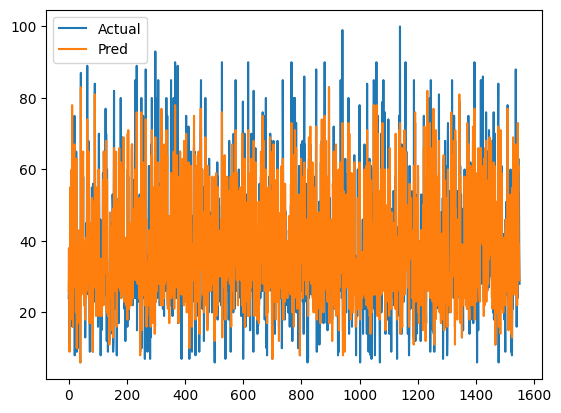

In [48]:
pd.DataFrame({'Actual' : y_val_age.values.astype(int),
              'Pred' : y_val_age_pred.reshape(-1,)
             }).plot()

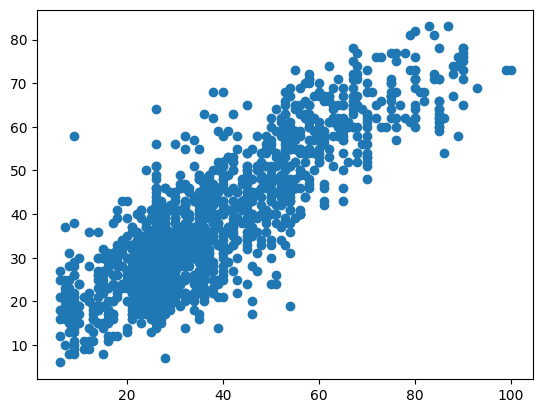

In [49]:
plt.scatter(y_val_age.values.astype(int), y_val_age_pred.reshape(-1,))

Learning rate set to 0.064321
0:	learn: 17.5882276	total: 8.62ms	remaining: 8.61s
1:	learn: 17.1196157	total: 16.3ms	remaining: 8.15s
2:	learn: 16.6763522	total: 24.4ms	remaining: 8.13s
3:	learn: 16.2594919	total: 31.8ms	remaining: 7.91s
4:	learn: 15.8721962	total: 39.8ms	remaining: 7.91s
5:	learn: 15.5102384	total: 47.3ms	remaining: 7.83s
6:	learn: 15.1857131	total: 54.9ms	remaining: 7.79s
7:	learn: 14.8891219	total: 62.5ms	remaining: 7.74s
8:	learn: 14.6236278	total: 69.8ms	remaining: 7.69s
9:	learn: 14.3555989	total: 77.3ms	remaining: 7.65s
10:	learn: 14.1136428	total: 84.7ms	remaining: 7.61s
11:	learn: 13.8968828	total: 92.1ms	remaining: 7.58s
12:	learn: 13.6734630	total: 99.7ms	remaining: 7.57s
13:	learn: 13.4912072	total: 107ms	remaining: 7.55s
14:	learn: 13.3052302	total: 115ms	remaining: 7.54s
15:	learn: 13.1228598	total: 122ms	remaining: 7.51s
16:	learn: 12.9694122	total: 129ms	remaining: 7.48s
17:	learn: 12.8302666	total: 137ms	remaining: 7.45s
18:	learn: 12.6776752	total: 14

=============== Age Prediction ===============

Train Accuracy :  4.286334469148127

Val Accuracy :  6.128975627925022

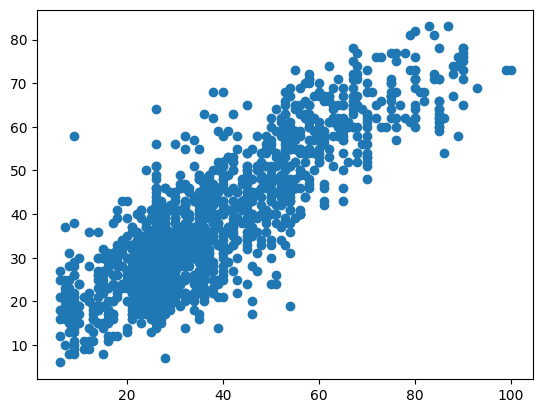

In [51]:
model = CatBoostRegressor()
model.fit(x_train_pca, y_train_age.values.astype(int))#, verbose = False)
y_val_pred_age = model.predict(x_val_pca)
print('=============== Age Prediction ===============')
print('Train Accuracy : ', mean_absolute_error(y_train_age.values, model.predict(x_train_pca)))
print('Val Accuracy : ', mean_absolute_error(y_val_age.values, y_val_pred_age))
plt.scatter(y_val_age.values.astype(int), y_val_age_pred.reshape(-1,))
plt.show()

In [52]:
pd.DataFrame({'Actual' : y_val_age.values.astype(int),
              'Pred' : y_val_pred_age.reshape(-1,)
             })

,Actual,Pred
0,24,28.006110
1,26,38.467265
2,36,33.225907
3,11,7.735422
4,25,20.607795
...,...,...
1546,63,60.658982
1547,40,35.250320
1548,53,41.959729
1549,36,38.756337


In [58]:
from keras.applications import VGG16, VGG19

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import os
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load your dataset (assuming it's already a DataFrame)
df =   # Ensure it has 'image_path' and 'category' columns

# Convert category to integer labels
categories = df['category'].unique()
category_to_index = {cat: i for i, cat in enumerate(categories)}
df['category'] = df['category'].map(category_to_index)

# Load and preprocess images
IMG_SIZE = 224
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)  # Load image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to 224x224
    img = img / 255.0  # Normalize
    return img

# Create dataset
X = np.array([load_and_preprocess_image(path) for path in df['image_path']])
y = np.array(df['category'])

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to categorical
num_classes = len(categories)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)

# Load VGG16 as feature extractor
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze layers

# Add custom classification head
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax')(x)

# Build model
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Save model
model.save("vgg16_custom.h5")

print("Model training complete and saved as 'vgg16_custom.h5'")


In [22]:
age_pred_df = age_df[['age', 'age_interval']].reset_index()
age_pred_df.head()

,images,age,age_interval
0,25_1_0_20170117140138784.jpg.chip.jpg,25,21 to 25
1,48_1_0_20170109220537701.jpg.chip.jpg,48,46 to 50
2,37_0_0_20170117183624982.jpg.chip.jpg,37,36 to 40
3,32_0_2_20170116162124916.jpg.chip.jpg,32,31 to 35
4,26_0_2_20170116182347867.jpg.chip.jpg,26,26 to 30


In [32]:
## Filter
# merged_df = merged_df[(merged_df.is_bw == False) & (~merged_df.age_interval.isin(['1 to 5']))]



train_age_df, val_age_df = train_test_split(age_pred_df, test_size = 0.1, shuffle = True, stratify = merged_df['age_interval'].values, random_state = 30980)
val_age_df, test_age_df = train_test_split(val_age_df, test_size = 0.2, shuffle = True, random_state = 30980)
print(train_age_df.shape, val_age_df.shape, test_age_df.shape)

# x_train = train_df.drop(['age',	'gender', 'race', 'age_interval'], axis = 1)
# x_val = val_df.drop(['age',	'gender', 'race', 'age_interval'], axis = 1)
# x_test = test_df.drop(['age', 'gender', 'race', 'age_interval'], axis = 1)

# y_train_age = train_df.age
# y_train_gender = train_df.gender
# y_train_race = train_df.race
# y_train_age_interval = train_df.age_interval

# y_val_age = val_df.age
# y_val_gender = val_df.gender
# y_val_race = val_df.race
# y_val_age_interval = val_df.age_interval

# y_test_age = test_df.age
# y_test_gender = test_df.gender
# y_test_race = test_df.race
# y_test_age_interval = test_df.age_interval

(19810, 3)
(1761, 3)
(441, 3)

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)  # Normalization
train_data_generator = datagen.flow_from_dataframe(
    dataframe=train_age_df,
    directory=data_dir, # Path to the directory containing images
    x_col='images', # Column containing image file paths
    y_col='age', # Column containing labels
    target_size=(200, 200), # Resize images to 224x224
    batch_size=32,
    class_mode='categorical', # 'binary' for two classes, 'categorical' for more
    seed=30980
)

val_data_generator = datagen.flow_from_dataframe(
    dataframe=val_age_df,
    directory=data_dir, # Path to the directory containing images
    x_col='images', # Column containing image file paths
    y_col='age', # Column containing labels
    target_size=(200, 200), # Resize images to 224x224
    batch_size=32,
    class_mode='categorical', # 'binary' for two classes, 'categorical' for more
    seed=30980
)

test_data_generator = datagen.flow_from_dataframe(
    dataframe=test_age_df,
    directory=data_dir, # Path to the directory containing images
    x_col='images', # Column containing image file paths
    y_col='age', # Column containing labels
    target_size=(200, 200), # Resize images to 224x224
    batch_size=32,
    class_mode='categorical', # 'binary' for two classes, 'categorical' for more
    seed=30980
)

Found 19810 validated image filenames belonging to 104 classes.
Found 1761 validated image filenames belonging to 95 classes.
Found 441 validated image filenames belonging to 78 classes.


In [42]:
base_model = keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(200, 200, 3),
    pooling=None,
    classes=104,
    classifier_activation="softmax",
    # name="resnet50",
)
base_model.trainable = False

# Add custom classification head
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(104, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
batch_size = 32
history = model.fit(
    train_data_generator,
    steps_per_epoch=50,
    epochs=10,
    # validation_data=val_data_generator,
    validation_steps=50
)

Epoch 1/10
50/50 [==============================] - 100s 2s/step - loss: 4.4160 - accuracy: 0.0894
Epoch 2/10
50/50 [==============================] - 101s 2s/step - loss: 4.4031 - accuracy: 0.0894
Epoch 3/10
50/50 [==============================] - 102s 2s/step - loss: 4.3672 - accuracy: 0.0975
Epoch 4/10
50/50 [==============================] - 102s 2s/step - loss: 4.3744 - accuracy: 0.0875
Epoch 5/10
50/50 [==============================] - 103s 2s/step - loss: 4.3505 - accuracy: 0.0988
Epoch 6/10
50/50 [==============================] - 103s 2s/step - loss: 4.3469 - accuracy: 0.0962
Epoch 7/10
50/50 [==============================] - 103s 2s/step - loss: 4.3132 - accuracy: 0.0938
Epoch 8/10
50/50 [==============================] - 103s 2s/step - loss: 4.3098 - accuracy: 0.0962
Epoch 9/10
50/50 [==============================] - 105s 2s/step - loss: 4.2946 - accuracy: 0.1019
Epoch 10/10
50/50 [==============================] - 105s 2s/step - loss: 4.2972 - accuracy: 0.0919


In [53]:
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model

In [55]:
model.predict(train_data_generator)

620/620 [==============================] - 1058s 2s/step


array([[0.02148435, 0.00929108, 0.00492547, ..., 0.00503633, 0.00539794,
        0.00472882],
       [0.02148435, 0.00929108, 0.00492547, ..., 0.00503633, 0.00539794,
        0.00472882],
       [0.02148435, 0.00929108, 0.00492547, ..., 0.00503633, 0.00539794,
        0.00472882],
       ...,
       [0.02148435, 0.00929108, 0.00492547, ..., 0.00503633, 0.00539794,
        0.00472882],
       [0.02148435, 0.00929108, 0.00492547, ..., 0.00503633, 0.00539794,
        0.00472882],
       [0.02148435, 0.00929108, 0.00492547, ..., 0.00503633, 0.00539794,
        0.00472882]], dtype=float32)

In [70]:
x_train_0 = train_df[train_df.gender == '0'].drop(['age',	'gender', 'race', 'age_interval'], axis = 1)
x_train_1 = train_df[train_df.gender == '1'].drop(['age',	'gender', 'race', 'age_interval'], axis = 1)

mean_0 = x_train_0.mean()
mean_1 = x_train_1.mean()

var_0 = np.linalg.inv(x_train_0.cov())
var_1 = np.linalg.inv(x_train_1.cov())



LinAlgError: Singular matrix

In [42]:
# Efficient row-wise computation
comp_0 = 1/(1 + np.sqrt(np.einsum('ij,jk,ik->i', x_train - mean_0, var_0, x_train - mean_0)))
comp_1 = 1/(1 + np.sqrt(np.einsum('ij,jk,ik->i', x_train - mean_1, var_1, x_train - mean_1)))


df = pd.DataFrame({
    'comp0': comp_0,
    'comp1': comp_1,
    'label': train_df['gender'].values
})

val = pd.DataFrame({
    'comp0': 1/(1 + np.sqrt(np.einsum('ij,jk,ik->i', x_val - mean_0, var_0, x_val - mean_0))),
    'comp1': 1/(1 + np.sqrt(np.einsum('ij,jk,ik->i', x_val - mean_1, var_1, x_val - mean_1))),
    'label': val_df['gender'].values
})

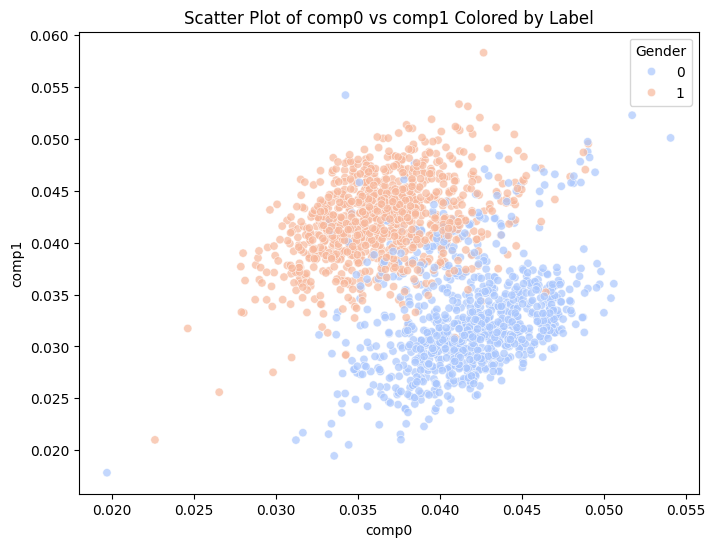

In [43]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.scatterplot(data=val, x="comp0", y="comp1", hue="label", palette="coolwarm", alpha=0.7)

# Show the plot
plt.title("Scatter Plot of comp0 vs comp1 Colored by Label")
plt.legend(title="Gender")
plt.show()


In [40]:
model = model_dict['KNN'](n_neighbors = 100)
model.fit(df[['comp0', 'comp1']], df['label'].values)#, verbose = False)
y_val_pred_gender = model.predict(df[['comp0', 'comp1']])
print(cr(df['label'].values, y_val_pred_gender))

precision    recall  f1-score   support

           0       0.96      0.96      0.96     11220
           1       0.95      0.95      0.95     10113

    accuracy                           0.96     21333
   macro avg       0.96      0.96      0.96     21333
weighted avg       0.96      0.96      0.96     21333

In [44]:
y_val_pred_gender = model.predict(val[['comp0', 'comp1']])
print(cr(val['label'].values, y_val_pred_gender))

precision    recall  f1-score   support

           0       0.91      0.90      0.91       915
           1       0.91      0.92      0.92       981

    accuracy                           0.91      1896
   macro avg       0.91      0.91      0.91      1896
weighted avg       0.91      0.91      0.91      1896

In [46]:
from depth.multivariate import *
variable_0 = mahalanobis(x_train.values, x_train_0.values, exact="True", mah_estimate="MCD", mah_parMcd = 0.75)
len(variable_0)

21333

In [47]:
variable_1 = mahalanobis(x_train.values, x_train_1.values, exact="True", mah_estimate="MCD", mah_parMcd = 0.75)
len(variable_1)


21333

In [48]:
maha_df = pd.DataFrame({
    'comp0': variable_0,
    'comp1': variable_1,
    'label': train_df['gender'].values
})

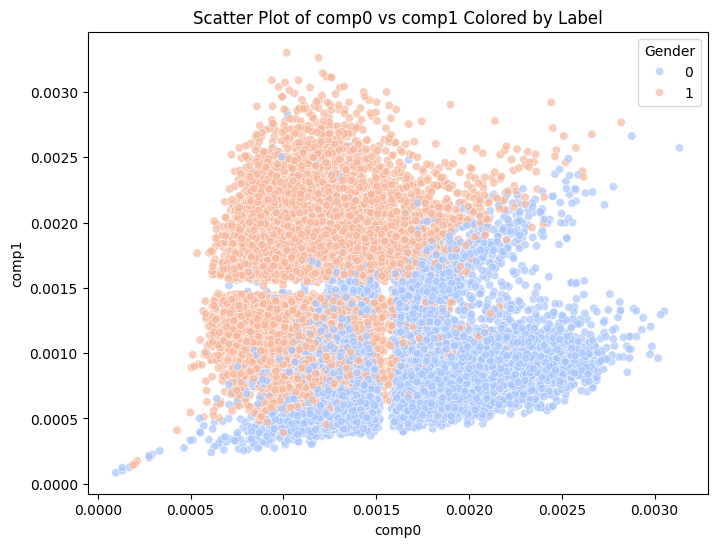

In [49]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.scatterplot(data=maha_df, x="comp0", y="comp1", hue="label", palette="coolwarm", alpha=0.7)

# Show the plot
plt.title("Scatter Plot of comp0 vs comp1 Colored by Label")
plt.legend(title="Gender")
plt.show()

In [ ]:
variable_0 = projection(x_train.values, x_train_0.values)
variable_1 = projection(x_train.values, x_train_1.values)

len(variable_0), len(variable_1)